<a href="https://colab.research.google.com/github/iskra3138/ImageSr/blob/master/2_TFRecord_%ED%8C%8C%EC%9D%BC_%EB%A7%8C%EB%93%A4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

참고 : https://codelabs.developers.google.com/codelabs/keras-flowers-data/#4

5종의 꽃 이미지 데이터를 TFRecord로 만드는 예제 코드입니다.

TFRecord만 만들 경우에는 GPU를 사용하지 않습니다. CPU instance만으로 가능합니다.

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt

In [0]:
# 폴더 구조를 쉽게 보기 위해서 tree 설치
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 1s (35.0 kB/s)
Selecting previously unselected package tree.
(Reading database ... 134443 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [0]:
#@title "display utilities [RUN ME]"
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(label.numpy().decode("utf-8"), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

## The flowers dataset

The flowers dataset consists of images of flowers with 5 possible class labels.

When training a machine learning model, we split our data into training and test datasets. We will train the model on our training data and then evaluate how well the model performs on data it has never seen - the test set.

In [0]:
from pathlib import Path
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = Path(data_dir)

228818944/228813984 [==============================] - 4s 0us/step


In [0]:
!tree -d {str(data_dir)}

/root/.keras/datasets/flower_photos
├── daisy
├── dandelion
├── roses
├── sunflowers
└── tulips

5 directories


In [0]:
SHARDS = 16 # TFRecord 파일을 16개 만들겠음
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips'] # do not change, maps to the labels in the data (folder names)

AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

DataSet나누고 TFRecord 만들기

In [0]:
import math

nb_images = len(tf.io.gfile.glob(str(Path(data_dir / '*/*.jpg')))) # 총 이미지 데이터 수 count
shard_size = math.ceil(1.0 * nb_images / SHARDS)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, SHARDS, shard_size))

Pattern matches 3670 images which will be rewritten as 16 .tfrec files containing 230 images each.


In [0]:
def read_file_and_label(filename):
  image_bits = tf.io.read_file(filename)## image_bits는 string으로 됩니다.
  
  # parse flower name from containing directory
  split_name = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
  file_name = split_name.values[-1] ## file_name은 파일명, 즉 string으로 됩니다. (향후 TFRecord 파일 만으로도 이미지의 이름을 알기 위해 추가했습니다.)
  label_name = split_name.values[-2] ## label_name은 폴더명, 즉 string으로 됩니다.
  label = tf.where(np.array(CLASSES)==label_name)[0][0] ## label은 integer가 됩니다.
  
  return image_bits, file_name, label_name, label

filenames = tf.data.Dataset.list_files(str(Path(data_dir / '*/*.jpg')), seed=35155) # This also shuffles the images
dataset1 = filenames.map(read_file_and_label, num_parallel_calls=AUTO)
dataset1 = dataset1.batch(shard_size)

In [0]:
# Three types of data can be stored in TFRecords: bytestrings, integers and floats
# They are always stored as lists, a single data element will be a list of size 1

def _bytestring_feature(list_of_bytestrings): # string
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def _float_feature(list_of_floats): # float32
  return tf.train.Feature(float_list=tf.train.FloatList(value=list_of_floats))
  

def to_tfrecord(tfrec_filewriter, img_bytes, file_name, label_name, label):  
  feature = {
      "image": _bytestring_feature([img_bytes]), # one image in the list
      "file_name": _bytestring_feature([file_name]),     # fixed length (1) list of strings, the text label
      "label_name": _bytestring_feature([label_name]),     # fixed length (1) list of strings, the text label
      "label": _int_feature([label]),     # fixed length (1) list of strings, the text label
      
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))
  
print("Writing TFRecords")

for shard, (bits, file_name, label_name, label) in enumerate(dataset1):
  # batch size used as shard size here
  shard_size = bits.numpy().shape[0]
  # good practice to have the number of records in the filename
  filename = './' + "{:02d}-{}.tfrec".format(shard, shard_size)
  
  with tf.io.TFRecordWriter(filename) as out_file:
    for i in range(shard_size):
      example = to_tfrecord(out_file,
                            bits.numpy()[i], 
                            file_name.numpy()[i],
                            label_name.numpy()[i],
                            label.numpy()[i]
                            )
      out_file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, shard_size))

Writing TFRecords
Wrote file ./00-230.tfrec containing 230 records
Wrote file ./01-230.tfrec containing 230 records
Wrote file ./02-230.tfrec containing 230 records
Wrote file ./03-230.tfrec containing 230 records
Wrote file ./04-230.tfrec containing 230 records
Wrote file ./05-230.tfrec containing 230 records
Wrote file ./06-230.tfrec containing 230 records
Wrote file ./07-230.tfrec containing 230 records
Wrote file ./08-230.tfrec containing 230 records
Wrote file ./09-230.tfrec containing 230 records
Wrote file ./10-230.tfrec containing 230 records
Wrote file ./11-230.tfrec containing 230 records
Wrote file ./12-230.tfrec containing 230 records
Wrote file ./13-230.tfrec containing 230 records
Wrote file ./14-230.tfrec containing 230 records
Wrote file ./15-220.tfrec containing 220 records


In [0]:
TARGET_SIZE = [224, 224]

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "file_name": tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "label_name": tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "label": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar, one integer
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    #image = tf.reshape(image, [*TARGET_SIZE, 3])
    image = tf.image.resize(image, TARGET_SIZE)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    file_name  = example['file_name']
    label_name  = example['label_name']
    label  = example['label']
    
    return image, file_name, label_name, label
    
# read from TFRecords. For optimal performance, read from multiple
# TFRecord files at once and set the option experimental_deterministic = False
# to allow order-altering optimizations.

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

filenames = tf.io.gfile.glob("./*.tfrec")
dataset4 = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
dataset4 = dataset4.with_options(option_no_order)
dataset4 = dataset4.map(read_tfrecord, num_parallel_calls=AUTO)
dataset4 = dataset4.shuffle(300)

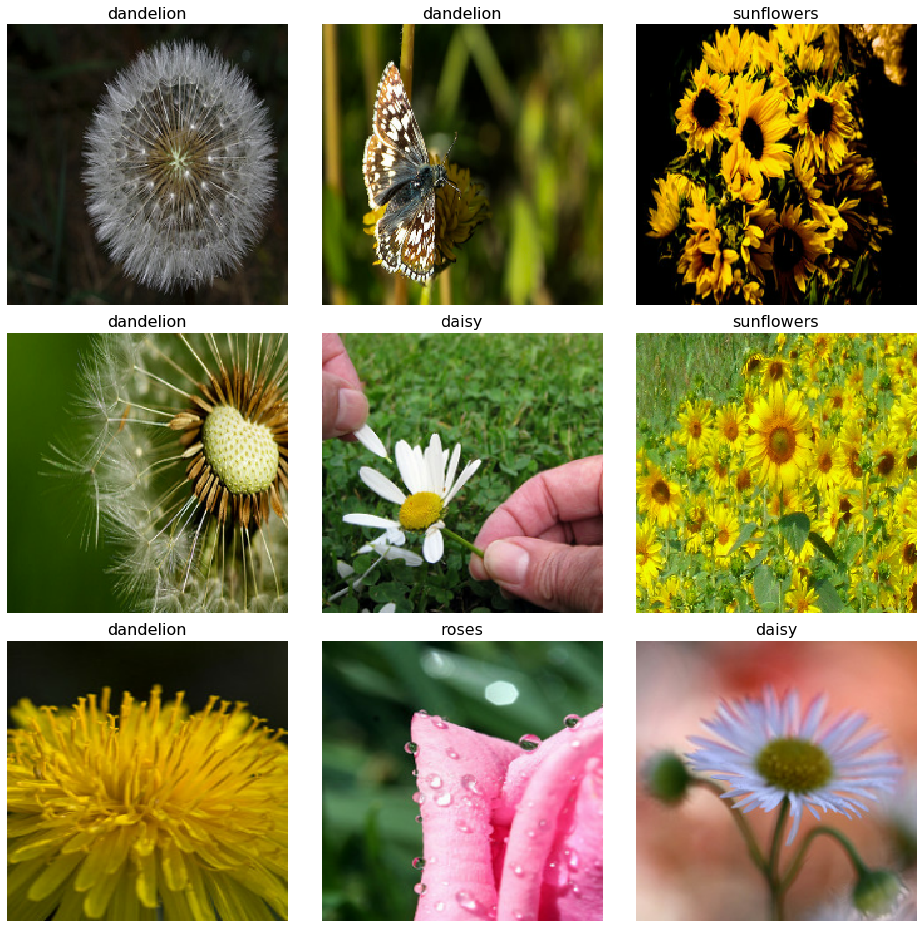

In [0]:
display_dataset = dataset4.map(lambda image, file_name, label_name, label: (image, label_name))
display_9_images_from_dataset(display_dataset)

In [0]:
for image, file_name, label_name, label in dataset4.take(300):
  print("Image shape {}, ({:>30},), ({:>10},), {}".format(image.numpy().shape, file_name.numpy().decode('utf8'), label_name.numpy().decode('utf8'), label.numpy()))

Image shape (224, 224, 3), (     2480853696_aacdbb5324.jpg,), ( dandelion,), 1
Image shape (224, 224, 3), (   8035908422_87220425d2_n.jpg,), (     roses,), 2
Image shape (224, 224, 3), (     6968202872_cfcb5b77fb.jpg,), ( dandelion,), 1
Image shape (224, 224, 3), (   3502251824_3be758edc6_m.jpg,), (    tulips,), 4
Image shape (224, 224, 3), (    23286304156_3635f7de05.jpg,), (sunflowers,), 3
Image shape (224, 224, 3), (   2254152047_d3bf8903cd_n.jpg,), (    tulips,), 4
Image shape (224, 224, 3), (   5762590366_5cf7a32b87_n.jpg,), ( dandelion,), 1
Image shape (224, 224, 3), (     8168031302_6e36f39d87.jpg,), ( dandelion,), 1
Image shape (224, 224, 3), (      367020749_3c9a652d75.jpg,), (     daisy,), 0
Image shape (224, 224, 3), (  17078716890_68e0723389_n.jpg,), (    tulips,), 4
Image shape (224, 224, 3), (   3407482427_49d5c75291_m.jpg,), (     roses,), 2
Image shape (224, 224, 3), (   5129135346_3fa8e804d8_n.jpg,), ( dandelion,), 1
Image shape (224, 224, 3), (  17388697431_0d84c427d1